In [1]:
import pandas as pd 
import numpy as np 
from scipy.signal import butter, filtfilt, iirnotch
import scipy.signal as signal
import matplotlib.pyplot as plt
from datetime import datetime
import os

## Compute metrics

In [23]:
def filter_data(data, fs=250, notch_f0 = 60, Q = 100):
  nyq = 0.5*fs
  order = 4
  # remove dc offset 
  b,a = butter(2, 1/nyq, 'highpass')
  y = filtfilt(b,a,data)

  b_notch, a_notch = iirnotch(notch_f0, Q, fs)
  y = filtfilt(b_notch, a_notch, y)

  return y

In [87]:
import warnings
warnings.filterwarnings('ignore')
import os 
from src.analyze.emg_processing import analyzeEMG

############### Change group here ############### 
data_dir = './openbci-data/g20/'
save_dir = './openbci-data/results/g20/'

for subdir, dirs, files in os.walk(data_dir):
    # print(subdir)
    counter = 0
    for file in files: 
        print(subdir, file)
        if os.path.join(subdir, file).endswith('csv'): 
            save_td_filepath = f'td_{subdir[-2:]}.csv'
            save_fd_filepath = f'fd_{subdir[-2:]}.csv'
            
            df = pd.read_table(subdir+'/'+file, header=None)
            data = df[1][250:-250] ## first 2 and last 2 seconds excluded
            middle_ind = int((len(data) - 1)/2)
            data = data[middle_ind-250:middle_ind+250] ## then only take middle 2 secs for processing
            y = filter_data(data)
            # print(y)
            result_dict = analyzeEMG(y, 250, False)
            
            df_td = pd.DataFrame(result_dict['TimeDomain'], index=[0])
            df_fd = pd.DataFrame(result_dict['FrequencyDomain'], index=[0])
            df_td['File'] = file[-8:-4]
            df_fd['File'] = file[-8:-4]

            if counter == 0: 
                df_td.to_csv((save_dir+save_td_filepath), index=False, mode='a');
                df_fd.to_csv((save_dir+save_fd_filepath), index=False, mode='a');
            else: 
                df_td.to_csv((save_dir+save_td_filepath), index=False, header=False, mode='a');
                df_fd.to_csv((save_dir+save_fd_filepath), index=False, header=False, mode='a');
        counter += 1

./openbci-data/g20/ .DS_Store
./openbci-data/g20/g20_U1 .DS_Store
./openbci-data/g20/g20_U1 BrainFlow-RAW_2023-02-10_11-35-44_7_T20_1.csv
[  78.88169557   55.71696471 -243.8309468  -421.2324455  -280.29371887
 -327.71591123 -287.73394171 -254.81655708 -211.12457038  -59.05531245
   22.85284228  234.96305269 -162.96122043 -396.7385187  -231.6677944
 -274.64570327 -263.0953074  -212.60893566 -126.65613485  -53.8357898
  103.02046762 -165.84363679 -276.66614357 -164.19397687 -140.00900114
  -76.40013676 -142.05710358 -143.83366197 -141.61947232  -57.80874246
 -219.99738169 -274.1277297    12.85104575  157.87033929  -35.29724396
 -224.66704444 -249.75641054 -220.75455847  -67.69079246  -30.14034737
  139.55883825  -27.15824484 -140.88221891 -148.11767019 -269.90899446
 -295.77766847 -108.76000045   40.12998372   -3.86826851   94.6236462
  316.91163497  150.25672405 -342.50115278 -256.28495227 -133.39747307
  -82.1508009  -102.99913726 -132.79522822 -170.39310436   34.24443071
  147.3035759

## Get averages

In [88]:
save_dir

'./openbci-data/results/g20/'

In [89]:
df_list = []
exp_list = []
for subdir, dirs, files in os.walk(save_dir):
    for file in files: 
        if os.path.join(subdir, file).endswith('csv'):
            df = pd.read_csv(os.path.join(subdir, file)) 
            df_list.append(df)
            exp_list.append(file[:-4]) 

In [90]:
len(df_list), len(exp_list)

(12, 12)

In [91]:
# df_list = [df_tdres]
# exp_list = ['td_U1']

mvc_levels = ['10', '20','50','80', '00']
mean_rows = ['10-mean', '20-mean', '50-mean', '80-mean', '100-mean']

In [92]:
for df in df_list: 
    for mvc in mvc_levels: 
        if mvc == '00': 
            row_name = '100-mean'
        else: 
            row_name = mvc+'-mean'
        df.loc[row_name] = df[df['File'].str.contains(mvc, na=False)].mean(numeric_only=True, axis=0,skipna=True)
        df.at[row_name, 'File'] = row_name 

In [93]:
for i,df in enumerate(df_list): 
    df_means = df[df.index.isin(mean_rows)]
    df_means.to_csv(save_dir+exp_list[i]+'.csv', index=False)

After this step, the files within save_dir are all the mean results computed from 2 collected trials. 

Now, **manually split the results into TD and FD to compute group means. 

## TD/FD mean of each group

In [102]:
dir = './openbci-data/results/g20/td/'

## manually change the dirs to get TD/FD means of a group

In [103]:
df_list = []
exp_list = []
for subdir, dirs, files in os.walk(dir):
    for file in files: 
        if os.path.join(subdir, file).endswith('csv'):
            df = pd.read_csv(os.path.join(subdir, file)) 
            df_list.append(df)
            exp_list.append(file[:-4]) 

In [104]:
df_all = pd.concat(df_list, ignore_index=True)

In [105]:
mean_rows = ['10-mean', '20-mean', '50-mean', '80-mean', '100-mean']
target_indices = []

df = df_all

for mean_row in mean_rows: 
    index = mean_row+'-all'
    target_indices.append(index)
    df.loc[index] = df[df['File'].str.contains(mean_row, na=False)].mean(numeric_only=True, axis=0,skipna=True)
    df.at[index, 'File'] = index 

In [106]:
df_means_all = df[df.index.isin(target_indices)]
df_means_all.to_csv(dir+'all_users_means.csv', index=False)

## Get Plots to compare the 2 groups

In [107]:
df_20_td = pd.read_csv('./openbci-data/results/g20/td/all_users_means.csv')
df_20_fd = pd.read_csv('./openbci-data/results/g20/fd/all_users_means.csv')
df_50_td = pd.read_csv('./openbci-data/results/g50/td/all_users_means.csv')
df_50_fd = pd.read_csv('./openbci-data/results/g50/fd/all_users_means.csv')

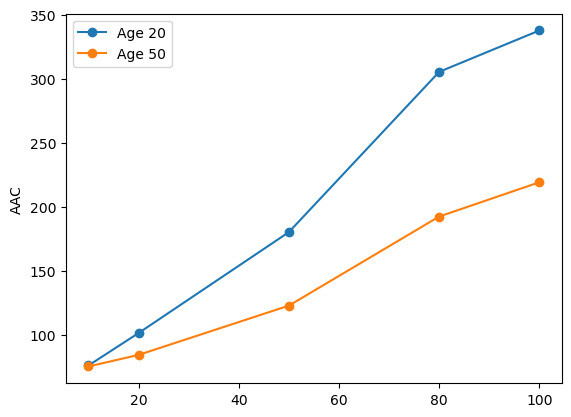

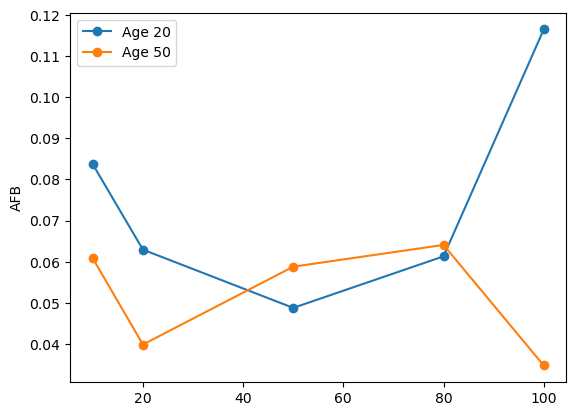

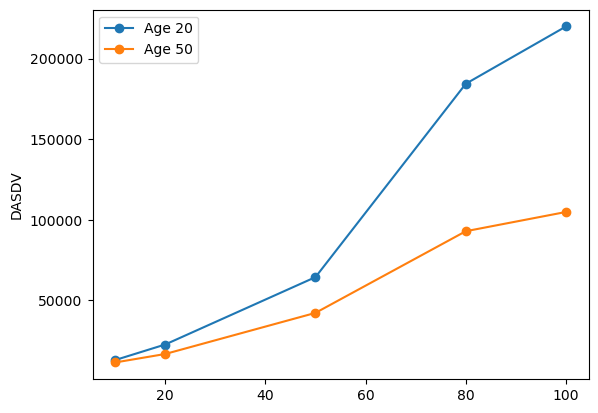

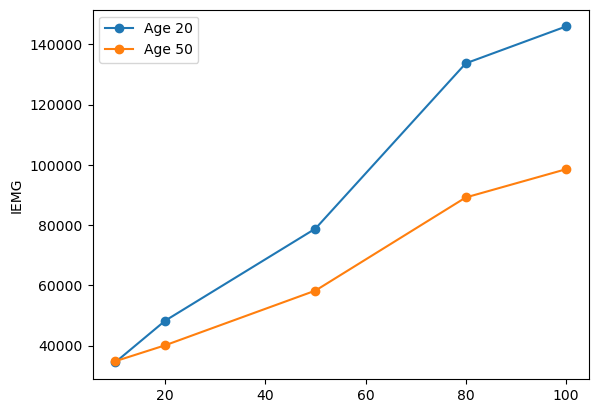

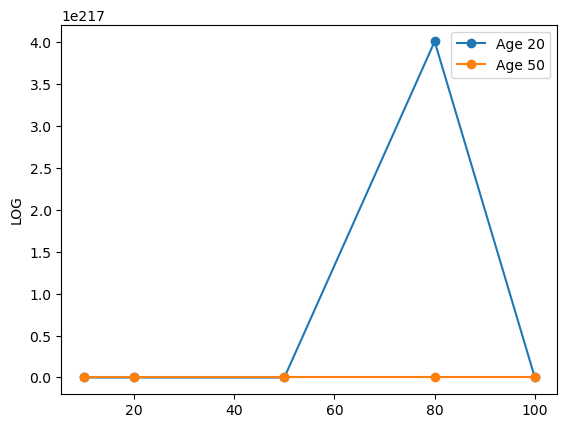

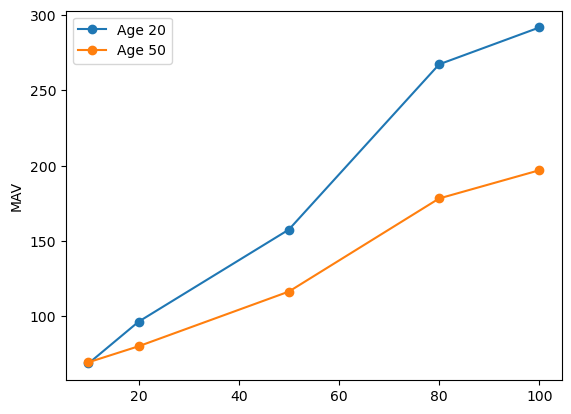

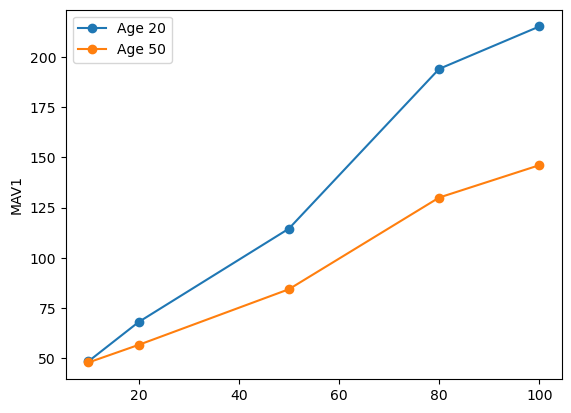

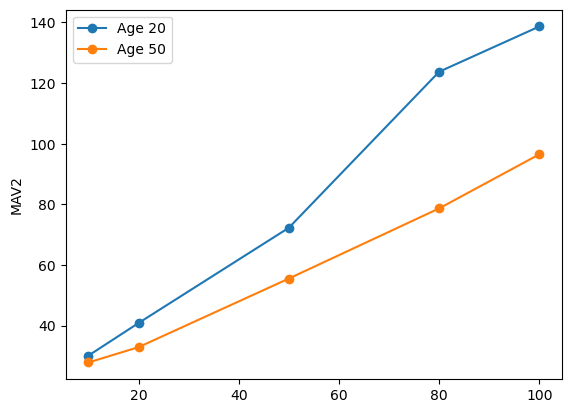

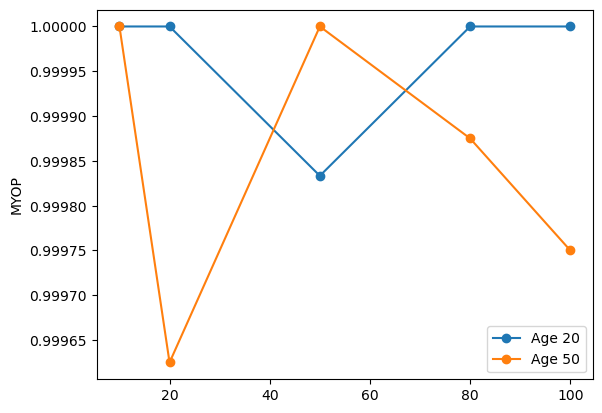

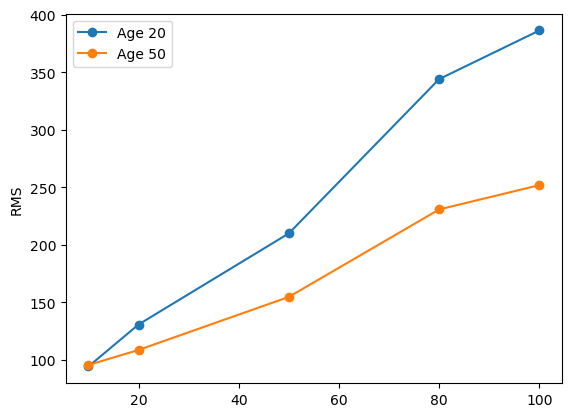

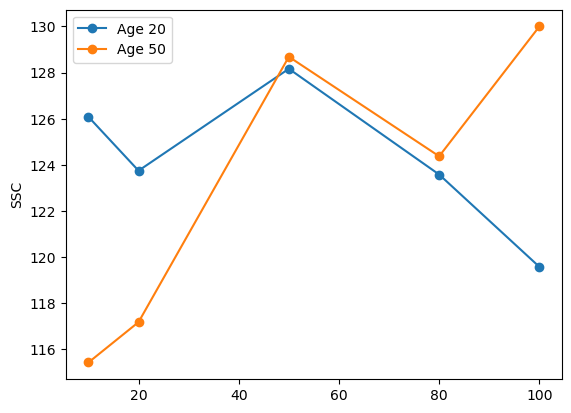

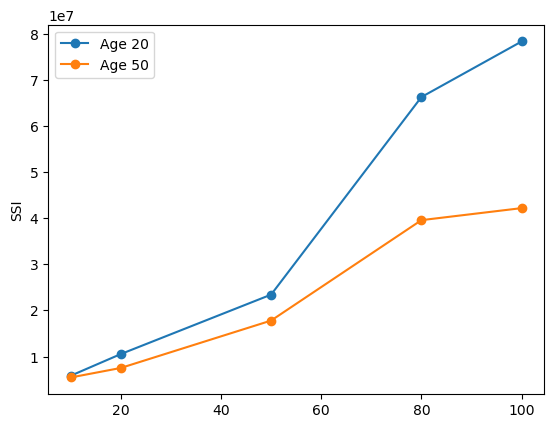

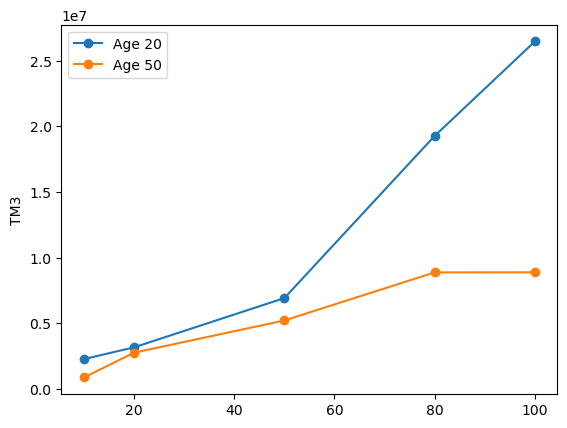

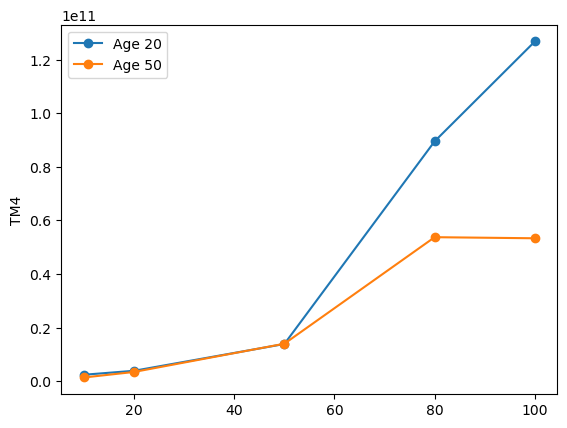

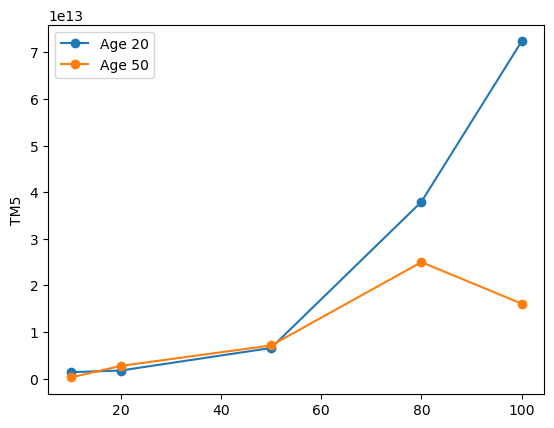

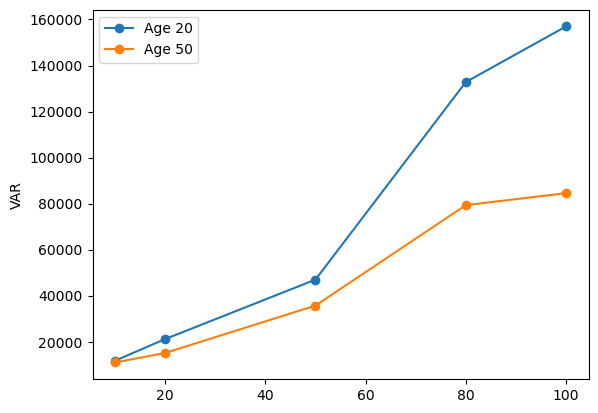

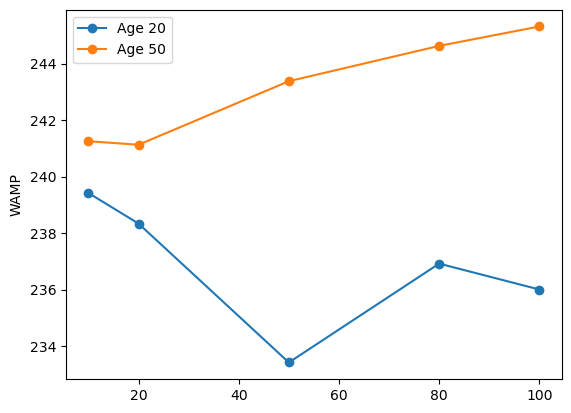

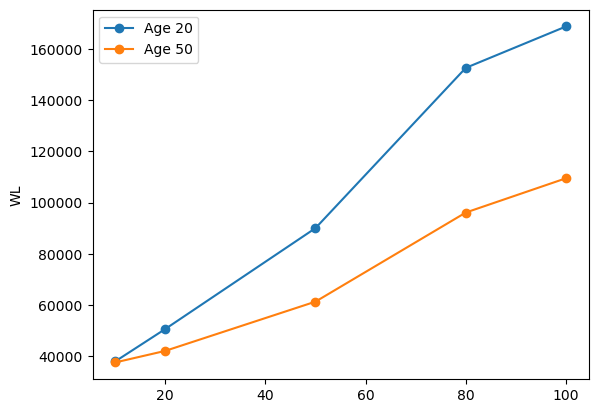

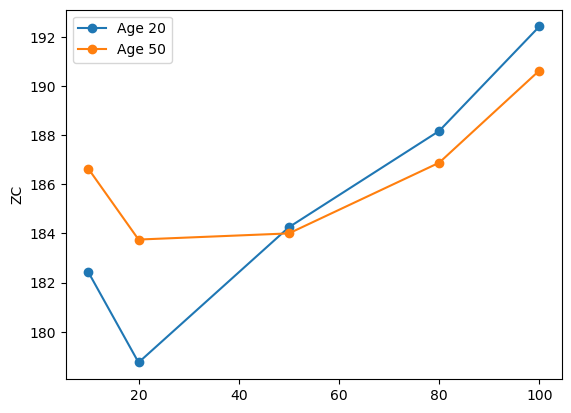

In [109]:
from matplotlib import pyplot as plt
%matplotlib inline

mvc_perc = [10, 20, 50, 80, 100]

cols = df_20_td.columns.difference(['File'])
for col in cols: 
    plt.figure()
    # print(len(data[col].tolist()))
    plt.plot(mvc_perc, df_20_td[col].tolist(), marker='o', label='Age 20') 
    plt.plot(mvc_perc, df_50_td[col].tolist(), marker='o', label='Age 50') 
    plt.ylabel(col)
    plt.legend()
    plt.show()

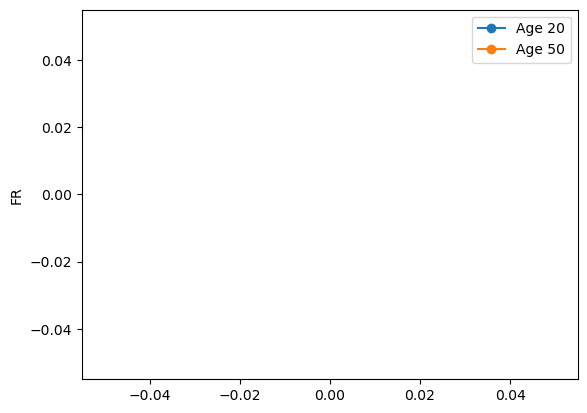

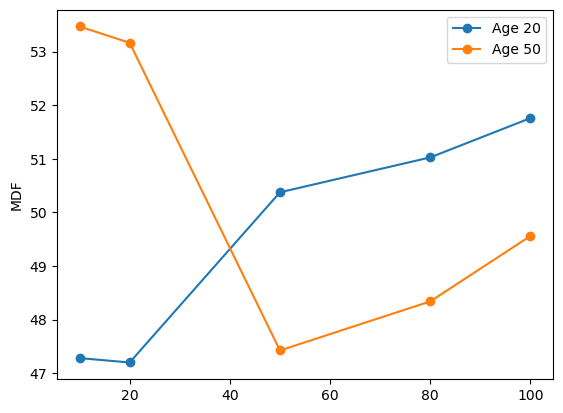

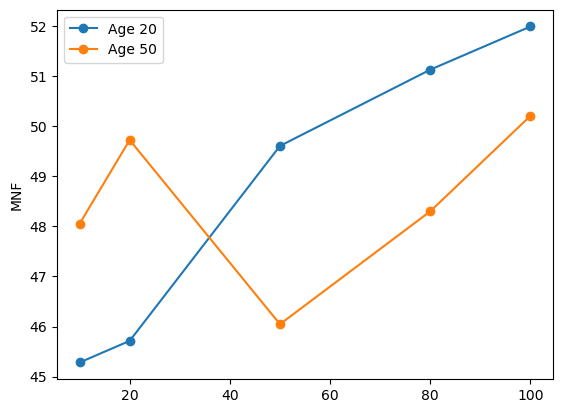

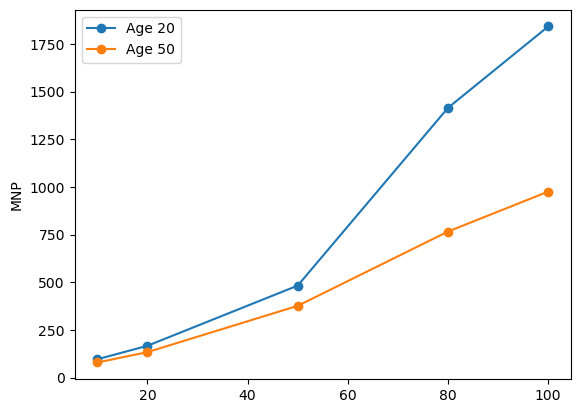

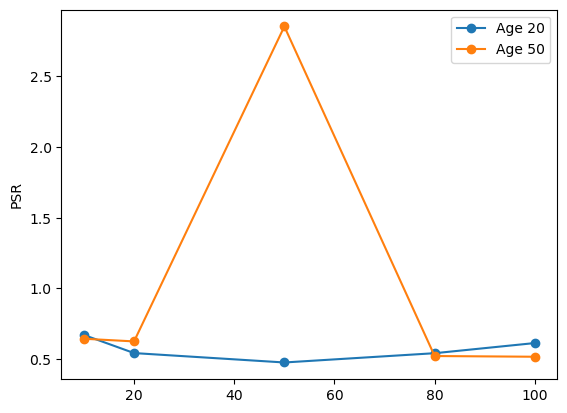

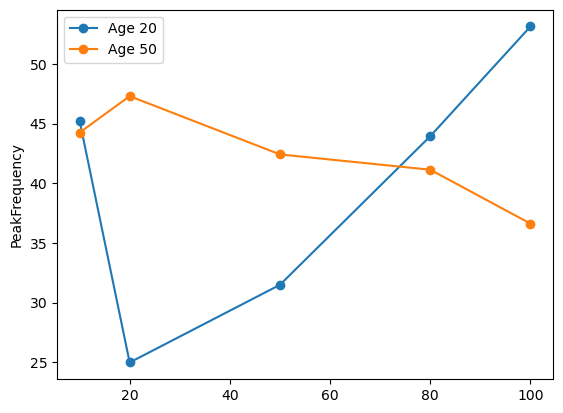

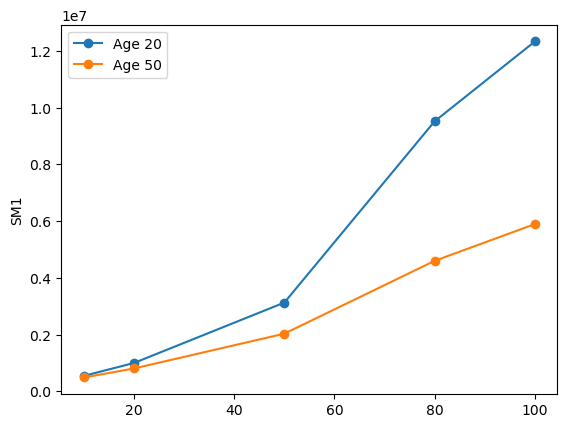

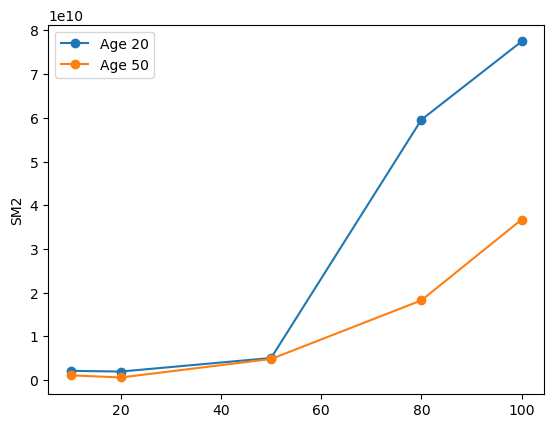

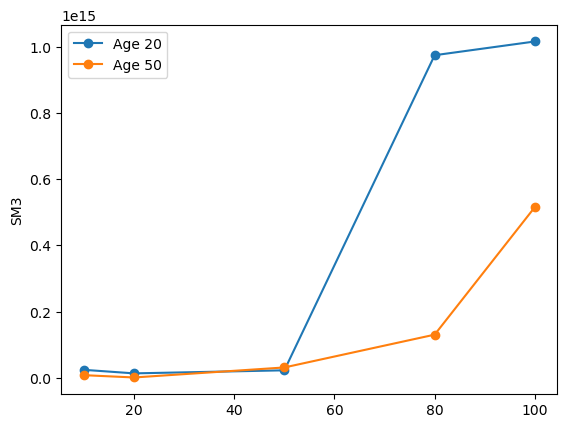

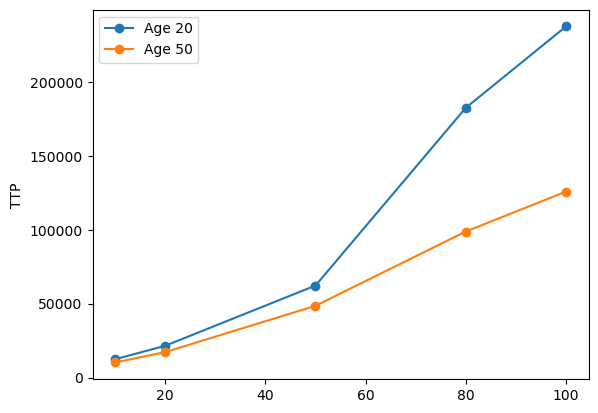

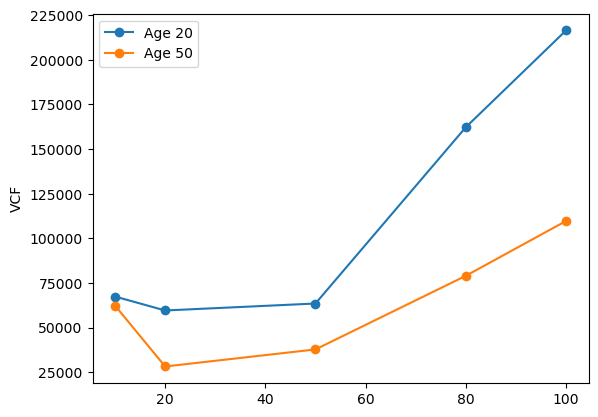

In [110]:
from matplotlib import pyplot as plt
%matplotlib inline

mvc_perc = [10, 20, 50, 80, 100]

cols = df_20_fd.columns.difference(['File'])
for col in cols: 
    plt.figure()
    # print(len(data[col].tolist()))
    plt.plot(mvc_perc, df_20_fd[col].tolist(), marker='o', label='Age 20') 
    plt.plot(mvc_perc, df_50_fd[col].tolist(), marker='o', label='Age 50') 
    plt.ylabel(col)
    plt.legend()
    plt.show()